# Risk Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/accepted_2007_to_2018Q4.csv', low_memory=False)

In [ ]:
# Check the first few rows
print(df.head())

         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   
3     14.85       829.90     C        C5  ...                            NaN   
4     22.45       289.91     F        F1  ...                            NaN   

  hardship_last_payment_amount disbursement_

In [ ]:
# Keep only the columns needed
cols_to_keep = ['loan_amnt', 'term', 'grade', 'annual_inc', 'dti', 'loan_status']
df = df[cols_to_keep]

**Data cleaning**

In [ ]:
df = df.dropna(subset=['loan_status', 'dti', 'grade'])

In [ ]:
df['term_months'] = df['term'].str.replace(' months', '').astype(int)

In [ ]:
df['is_default'] = df['loan_status'].isin(['Charged Off', 'Default']).astype(int)

In [ ]:
# Check overall default rate
print(f"Default rate: {df['is_default'].mean():.1%}")

Default rate: 17.2%


In [ ]:
# Check the first few rows
print(df.head())

   loan_amnt        term grade  annual_inc    dti loan_status  term_months  \
0     3600.0   36 months     C     55000.0   5.91  Fully Paid           36   
1    24700.0   36 months     C     65000.0  16.06  Fully Paid           36   
2    20000.0   60 months     B     63000.0  10.78  Fully Paid           60   
3    35000.0   60 months     C    110000.0  17.06     Current           60   
4    10400.0   60 months     F    104433.0  25.37  Fully Paid           60   

   is_default  
0           0  
1           0  
2           0  
3           0  
4           0  


**BNPL-specific feature engineering**

In [ ]:

df['loan_to_income'] = df['loan_amnt'] / df['annual_inc']

In [ ]:
df['small_purchase'] = (df['loan_amnt'] < 1000).astype(int)

In [ ]:
df['dti_bucket'] = pd.cut(df['dti'], bins=[0, 10, 20, 30, 100])

**Risk segmentation (alternative to missing 'earliest_cr_line')**

In [ ]:
conditions = [
    (df['grade'].isin(['A','B'])) & (df['dti'] < 15),
    (df['grade'].isin(['F','G'])) | (df['dti'] > 35)
]

In [ ]:
choices = ['Low Risk', 'High Risk']
df['risk_segment'] = np.select(conditions, choices, default='Medium Risk')

**Analysis 1: Default rate by grade**

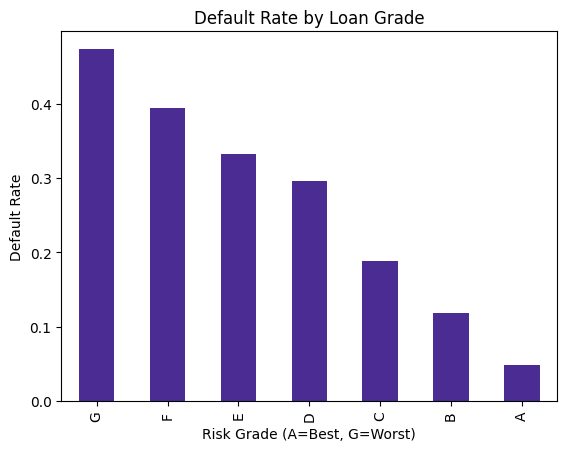

In [ ]:
default_by_grade = df.groupby('grade')['is_default'].mean().sort_values(ascending=False)
default_by_grade.plot(kind='bar', color='#4A2C92')  # Using Tabby's brand color
plt.title('Default Rate by Loan Grade')
plt.ylabel('Default Rate')
plt.xlabel('Risk Grade (A=Best, G=Worst)')
plt.savefig('default_by_grade.png')

**Analysis 2: Default rate by DTI**

<ipython-input-16-6c0a4f3a0928>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_by_dti = df.groupby('dti_bucket')['is_default'].mean()


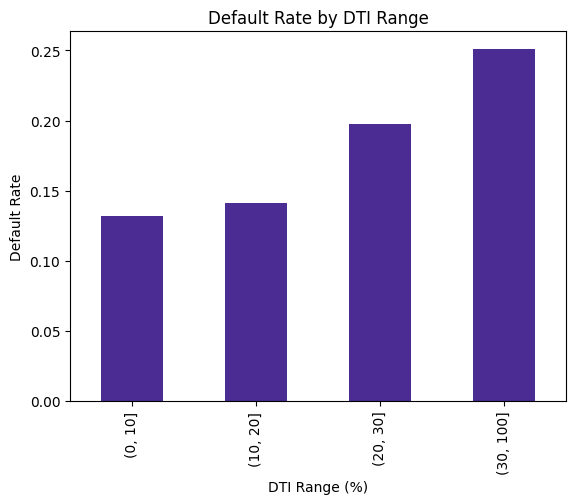

In [ ]:
default_by_dti = df.groupby('dti_bucket')['is_default'].mean()
default_by_dti.plot(kind='bar', color='#4A2C92')
plt.title('Default Rate by DTI Range')
plt.ylabel('Default Rate')
plt.xlabel('DTI Range (%)')
plt.savefig('default_by_dti.png')

**Analysis 3: Risk matrix**

<ipython-input-17-77ea2d056b5d>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  risk_matrix = df.pivot_table(index='grade', columns='dti_bucket', values='is_default', aggfunc='mean')


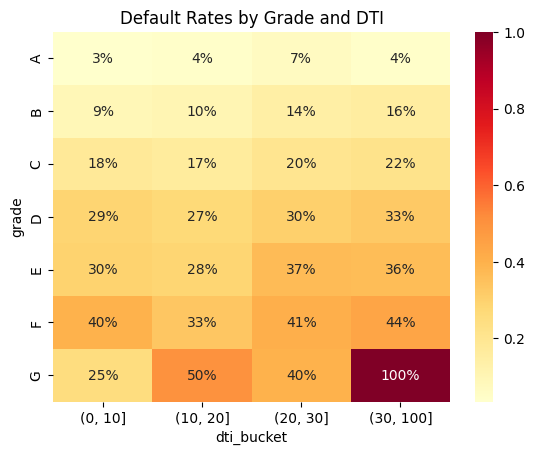

In [ ]:
risk_matrix = df.pivot_table(index='grade', columns='dti_bucket', values='is_default', aggfunc='mean')
sns.heatmap(risk_matrix, annot=True, fmt=".0%", cmap="YlOrRd")
plt.title('Default Rates by Grade and DTI')
plt.savefig('risk_matrix.png')

**Additional BNPL-relevant analysis**

In [ ]:
small_purchase_risk = df.groupby('small_purchase')['is_default'].mean()
term_risk = df.groupby('term_months')['is_default'].mean()

In [ ]:
df.to_csv('tabby_risk_analysis_enhanced.csv', index=False)
risk_matrix.to_csv('risk_matrix.csv')